Portfolio Metrics for the Highest Sharpe Ratio Portfolio:
 
Number of porfolios analyzed: 100000
Returns: 33.40%
Risk (Standard Deviation): 18.54%
Sharpe Ratio: 1.50
 
Portfolio Value: $7844.35
Risk Free Rate: 5.58%
 
To achieve a risk tolerance of 20.00%:, modify your portfolio as follows:

   Symbol  Buy/Sell  CurrentSharePrice  CurrentValue   Shares  TargetValue  ValueAfterAction  SharesAfterAction  TargetSharpeWeight  ActualWeightAfterAction
1    SPYG     -35.0            59.1100       2316.85  39.1955       235.21            248.00             4.1955            2.998416                 3.140095
9    EELV     -22.0            21.9514        492.06  22.4160        11.36              9.13             0.4160            0.144823                 0.115601
6     EFV     -14.0            47.2100        720.76  15.2672        73.21             59.82             1.2672            0.933300                 0.757421
3    SGDJ     -10.0            27.1472        407.21  15.0000       140.33     

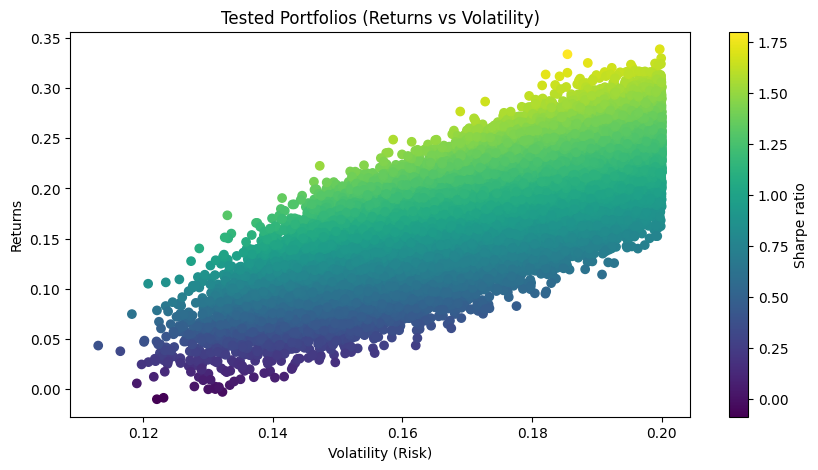

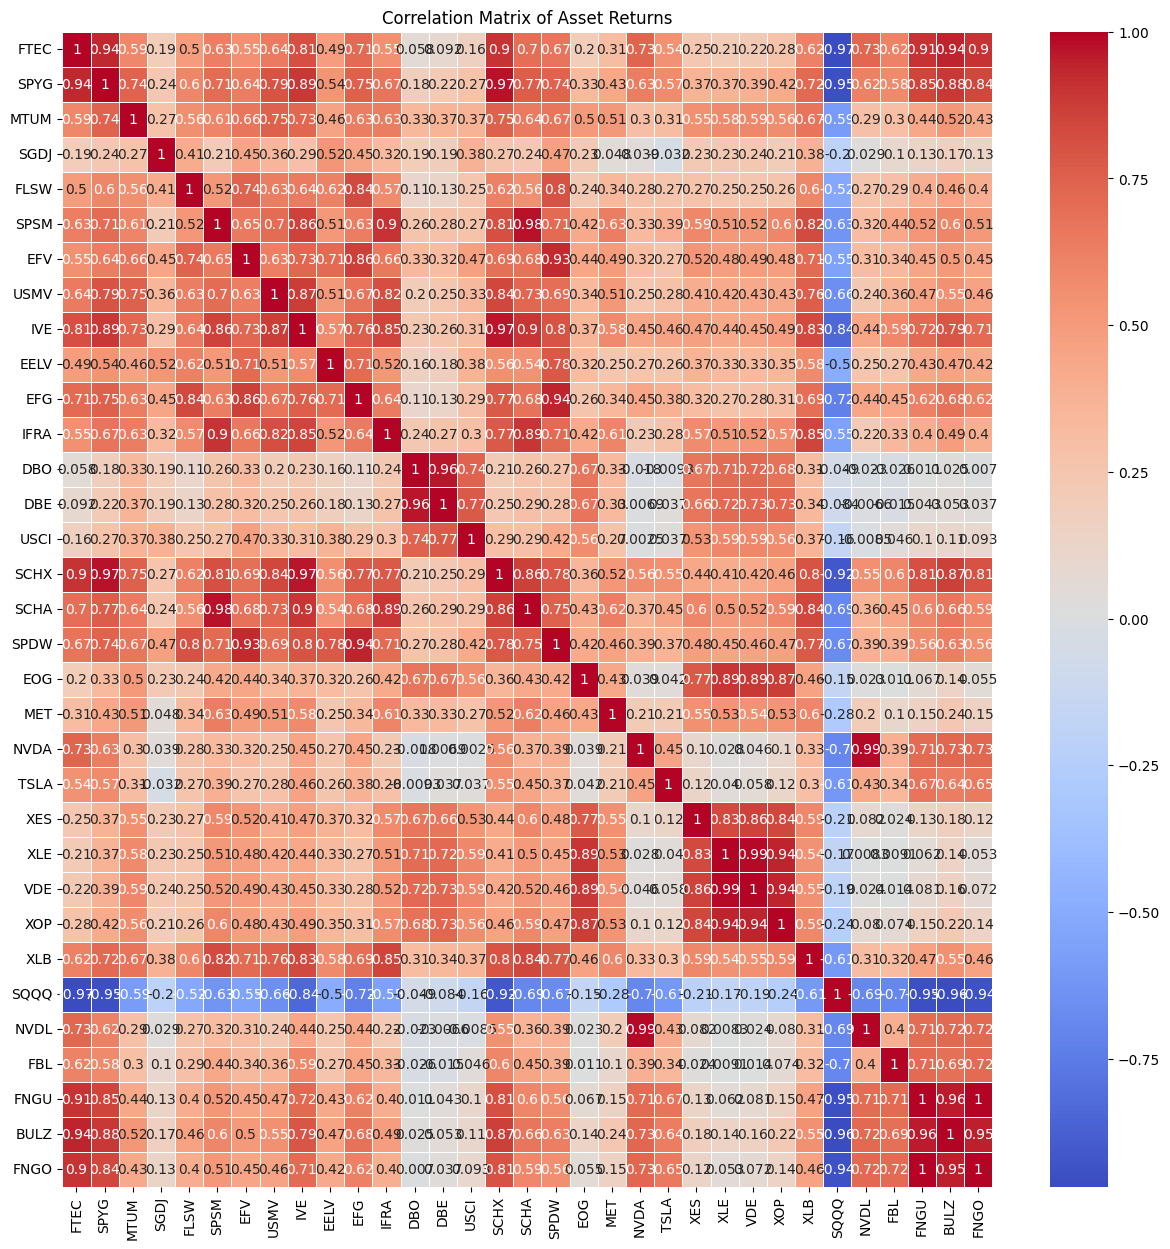

In [4]:
import os

# Third-party imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

import functions as f

# Load environment variables
load_dotenv()

api_key = os.getenv('FMPKEY')   

STOCKS = [
    'FTEC', 'SPYG', 'MTUM', 'SGDJ', 'FLSW', 'SPSM', 'EFV', 'USMV', 'IVE',
    'EELV', 'EFG', 'IFRA', 'DBO', 'DBE', 'USCI', 'SCHX', 'SCHA', 'SPDW',
    'EOG', 'MET', 'NVDA', 'TSLA', 
    'XES', 'XLE', 'VDE', 'XOP', 'XLB', 'SQQQ',
    'NVDL', 'FBL', 'FNGU', 'BULZ', 'FNGO'
]
ACCT = 7844.35   # Account balance
RISK = 0.2  # Risk tolerance
RF = f.get_treasury_data()
RF = RF[0]["month3"]/100 #0.0561  # 3 Month Treasury Rate
NUMBER_OF_PORTFOLIOS = 100000  # Number of portfolios to simulate
TRADING_DAYS = 252  # Number of trading days in a year
NUMBER_OF_DAYS = 300  # Number of days to simulate (history)

stock_history = {}

# Get all prices into a dataframe
base_url = 'https://financialmodelingprep.com/api/v3/historical-price-full/'
for stock in STOCKS:
    url = f'{base_url}{stock}?serietype=line&apikey={api_key}'
    prices = requests.get(url).json()
    prices_df = pd.DataFrame(prices['historical'])

    # Ensure the data is sorted by date in descending order (most recent first)
    prices_df['date'] = pd.to_datetime(prices_df['date'])
    prices_df = prices_df.sort_values('date', ascending=True)

    # Select closing prices for the chosen number of days
    recent_prices = prices_df.tail(NUMBER_OF_DAYS).set_index('date')['close']
    stock_history[stock] = recent_prices

# Concatenate all stock close prices into a single dataframe
portfolio = pd.concat(stock_history, axis=1)

# Calculate daily returns
return_stocks = portfolio.pct_change().dropna()

# Calculate mean returns and covariances of all assets
portfolio_returns = []
portfolio_risk = []
sharpe_ratio_port = []
portfolio_weights = []

for portfolio in range(NUMBER_OF_PORTFOLIOS):
    weights = np.random.random_sample(len(STOCKS))
    weights = weights / np.sum(weights)
    annualize_return = np.sum((return_stocks.mean() * weights) * TRADING_DAYS) - RF
    portfolio_returns.append(annualize_return)

    matrix_covariance_portfolio = (return_stocks.cov()) * TRADING_DAYS
    portfolio_variance = np.dot(weights.T, np.dot(matrix_covariance_portfolio, weights))
    portfolio_standard_deviation = np.sqrt(portfolio_variance)
    portfolio_risk.append(portfolio_standard_deviation)

    sharpe_ratio = ((annualize_return - RF) / portfolio_standard_deviation)
    sharpe_ratio_port.append(sharpe_ratio)

    portfolio_weights.append(weights)

# Convert lists to arrays outside the loop
portfolio_risk = np.array(portfolio_risk)
portfolio_returns = np.array(portfolio_returns)
sharpe_ratio_port = np.array(sharpe_ratio_port)

# Filtering portfolios by RISK
indices_within_risk = np.where(portfolio_risk <= RISK)[0]

portfolio_risk = portfolio_risk[indices_within_risk]
portfolio_returns = portfolio_returns[indices_within_risk]
sharpe_ratio_port = sharpe_ratio_port[indices_within_risk]
portfolio_weights = np.array(portfolio_weights)[indices_within_risk]

# Create a dataframe with the returns and risk values of each portfolio
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_risk, portfolio_returns, c=portfolio_returns / portfolio_risk)
plt.xlabel('Volatility (Risk)')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe ratio')
plt.title('Tested Portfolios (Returns vs Volatility)')

porfolio_metrics = [portfolio_returns, portfolio_risk, sharpe_ratio_port, portfolio_weights]
portfolio_dfs = pd.DataFrame(porfolio_metrics).T

# Rename the columns:
portfolio_dfs.columns = ['Port Returns', 'Port Risk', 'Sharpe Ratio', 'Portfolio Weights']

# Convert from object to float the first three columns.
for col in ['Port Returns', 'Port Risk', 'Sharpe Ratio']:
    portfolio_dfs[col] = portfolio_dfs[col].astype(float)

highest_sharpe_port = portfolio_dfs.iloc[portfolio_dfs['Sharpe Ratio'].idxmax()]
highest_sharpe_weights = highest_sharpe_port['Portfolio Weights']

current_portfolio = pd.read_csv('C:/Users/thomas.higginbotham/OneDrive/PortfolioMagic/portfolio.csv')
#current_portfolio = pd.read_csv('/Users/thomashigginbotham/Library/CloudStorage/OneDrive-Personal/PortfolioMagic/portfolio.csv')

# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
# Display full content of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.width', None)  # Width of the display in characters
# Disable wrapping of the info across multiple lines
pd.set_option('display.expand_frame_repr', False)

# Get buy/sell recommendations
recommendations = f.compute_buy_sell_recommendations(
    current_portfolio, ACCT, highest_sharpe_weights, STOCKS, stock_history)

recommendations = recommendations.loc[(recommendations['CurrentValue'] != recommendations['ValueAfterAction']) | ((recommendations['CurrentValue'] != 0) & (recommendations['ValueAfterAction'] != 0))]

# Printing the asset symbols along with their respective weights

# Extracting and printing the metrics
print(f"Portfolio Metrics for the Highest Sharpe Ratio Portfolio:")
print(f" ")
print(f"Number of porfolios analyzed: {NUMBER_OF_PORTFOLIOS}")
print(f"Returns: {highest_sharpe_port['Port Returns']*100:.2f}%")
print(
    f"Risk (Standard Deviation): {highest_sharpe_port['Port Risk']*100:.2f}%")
print(f"Sharpe Ratio: {highest_sharpe_port['Sharpe Ratio']:.2f}")
print(f' ')
print(f'Portfolio Value: ${ACCT:.2f}')
print(f'Risk Free Rate: {RF*100:.2f}%')
print(f' ')
print(f'To achieve a risk tolerance of {RISK*100:.2f}%:, modify your portfolio as follows:')
print(f'')
print(recommendations)

# Calculate the correlation matrix
correlation_matrix = return_stocks.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Asset Returns")
plt.show()

In [9]:
recommendations.to_csv('C:/Users/thomas.higginbotham/OneDrive/exported_portfolio.csv')